# Carbon emissions
This notebook analyzes carbon emissions through time, across countries and industries.
---



Data source = Carbon Monitor: https://carbonmonitor.org, it's an amazing resource

In [2]:
import pandas as pd          # This library is for data wrangling
import seaborn as sns        # This is one library for plotting
import plotly.express as px  # This is another library for plots 

url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'
data_carbon = pd.read_csv(url, skiprows = 0)
data_carbon['date'] = pd.to_datetime(data_carbon['date'],format='%d/%m/%Y') # Correct date format
data_carbon

,country,date,sector,value,timestamp
0,Brazil,2019-01-01,Power,0.108768,1546272000
1,China,2019-01-01,Power,14.251000,1546272000
2,EU27 & UK,2019-01-01,Power,1.676920,1546272000
3,France,2019-01-01,Power,0.049075,1546272000
4,Germany,2019-01-01,Power,0.349691,1546272000
...,...,...,...,...,...
76603,Russia,2021-06-30,International Aviation,0.020850,1624982400
76604,Spain,2021-06-30,International Aviation,0.028848,1624982400
76605,UK,2021-06-30,International Aviation,0.028976,1624982400
76606,US,2021-06-30,International Aviation,0.140004,1624982400


This data is sampled at the daily frequency: that's a lot!
Let us aggregate the values into monthly emissions. 
This can be done with pivot tables.


In [3]:
data_carbon['year'] = pd.DatetimeIndex(data_carbon['date']).year    # First add year
data_carbon['month'] = pd.DatetimeIndex(data_carbon['date']).month  # & add month
data_carbon['year_month'] = data_carbon['year'].astype(str).str.cat(data_carbon['month'].astype(str))

data_m = data_carbon.pivot_table(values=['value'], 
                                 aggfunc='sum', 
                                 index=['country', 'sector', 'year', 'month', 'year_month']).reset_index()
data_m['day'] = 15                                                  # Say, middle of the month..
data_m['date'] = pd.to_datetime(data_m[['year', 'month', 'day']])
data_m

,country,sector,year,month,year_month,value,day,date
0,Brazil,Domestic Aviation,2019,1,20191,0.969131,15,2019-01-15
1,Brazil,Domestic Aviation,2019,2,20192,0.801970,15,2019-02-15
2,Brazil,Domestic Aviation,2019,3,20193,0.834112,15,2019-03-15
3,Brazil,Domestic Aviation,2019,4,20194,0.769131,15,2019-04-15
4,Brazil,Domestic Aviation,2019,5,20195,0.739430,15,2019-05-15
...,...,...,...,...,...,...,...,...
2515,WORLD,Residential,2021,2,20212,440.018200,15,2021-02-15
2516,WORLD,Residential,2021,3,20213,363.678140,15,2021-03-15
2517,WORLD,Residential,2021,4,20214,281.703960,15,2021-04-15
2518,WORLD,Residential,2021,5,20215,204.834200,15,2021-05-15


# Country focus
Let's zoom briefly on one country, say, the US.

In [4]:
data_m[data_m['country']=="US"]

,country,sector,year,month,year_month,value,day,date
2160,US,Domestic Aviation,2019,1,20191,13.465002,15,2019-01-15
2161,US,Domestic Aviation,2019,2,20192,12.865129,15,2019-02-15
2162,US,Domestic Aviation,2019,3,20193,14.441102,15,2019-03-15
2163,US,Domestic Aviation,2019,4,20194,14.169614,15,2019-04-15
2164,US,Domestic Aviation,2019,5,20195,15.004223,15,2019-05-15
...,...,...,...,...,...,...,...,...
2335,US,Residential,2021,2,20212,89.022220,15,2021-02-15
2336,US,Residential,2021,3,20213,62.583360,15,2021-03-15
2337,US,Residential,2021,4,20214,41.038089,15,2021-04-15
2338,US,Residential,2021,5,20215,28.938996,15,2021-05-15


Now let's have a look!

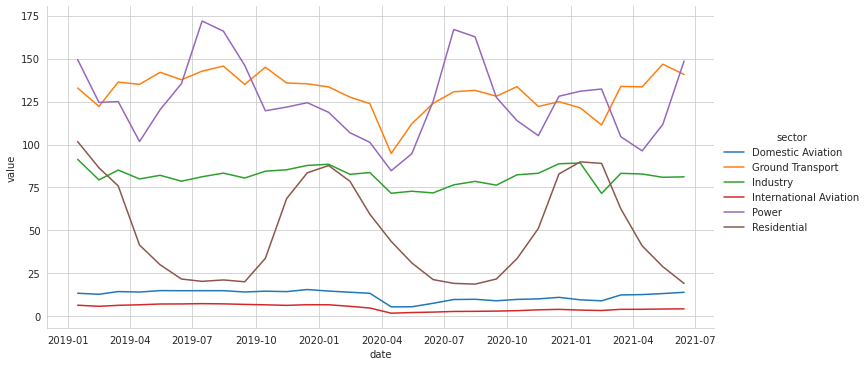

In [5]:
sns.set_style("whitegrid")
sns.relplot(
    data = data_m.query('country == "US"'),   # Data source = the filtered data (other method)
    kind = "line",                            # Graph type = line
    x = "date",                               # x-axis = Date column (of course!)
    y = "value",                              # y-axis = the normalised Close column
    hue = "sector",                           # One color for each sector
    aspect = 2
)


How about in relative terms?

In [6]:
data_m_US = data_m.query('country == "US"').reset_index() # Intermediate dataset
data_m_US['rel_value'] = data_m_US.groupby('date')['value'].transform(lambda x: x/sum(x))

fig = px.bar(data_m_US, 
             x = "date", 
             y = "rel_value", 
             color = "sector", 
             title = "Relative emissions")
fig.show()

# Cross-country analysis
Now, let's compare country emissions.  
We aggregate all sectors to ease the visualization.   
This requires a new pivot table.   


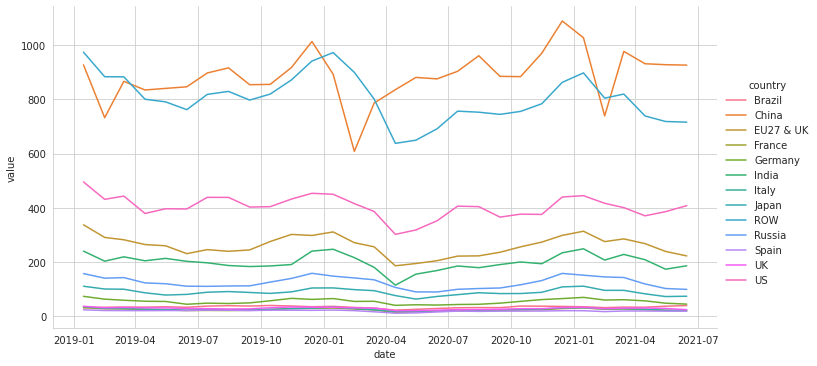

In [7]:
data_country = data_m.pivot_table(values = 'value', aggfunc = 'sum', index = ['country', 'date']).reset_index()
sns.set_style("whitegrid")
sns.relplot(
    data = data_country.query('country != "WORLD"'),   # Data source = the filtered data (other method)
    kind = "line",                            # Graph type = line
    x = "date",                               # x-axis = Date column (of course!)
    y = "value",                              # y-axis = the normalised Close column
    hue = "country",                           # One color for each sector
    aspect = 2
)

The blue line above ROW = *rest of the world*.  
The three main emitters are China, the US and Europe.

# Economic activity
In order to pursue our analysis, we need data pertaining to other indicators. Let's have a look at the economy.

In [8]:
url = 'https://www.imf.org/imf/weodatabase/downloadreport?c=512,914,612,614,311,213,911,314,193,122,912,313,419,513,316,913,124,339,638,514,218,963,616,223,516,918,748,618,624,522,622,156,626,628,228,924,233,632,636,634,238,662,960,423,935,128,611,321,243,248,469,253,642,643,939,734,644,819,172,132,646,648,915,134,652,174,328,258,656,654,336,263,268,532,944,176,534,536,429,433,178,436,136,343,158,439,916,664,826,542,967,443,917,544,941,446,666,668,672,946,137,546,674,676,548,556,678,181,867,682,684,273,868,921,948,943,686,688,518,728,836,558,138,196,278,692,694,962,142,449,564,565,283,853,288,293,566,964,182,359,453,968,922,714,862,135,716,456,722,942,718,724,576,936,961,813,726,199,733,184,524,361,362,364,732,366,144,146,463,528,923,738,578,537,742,866,369,744,186,925,869,746,926,466,112,111,298,927,846,299,582,487,474,754,698,&s=NGDPD,PPPGDP,NGDPDPC,PPPPC,&sy=1980&ey=2026&ssm=0&scsm=1&scc=0&ssd=1&ssc=0&sic=1&sort=subject&ds=.&br=1&wsid=9335dcb0-fe3f-4d14-93e3-2a34483cfc3a'
data_eco = pd.read_csv(url, skiprows = 0, sep='\t', encoding='UTF-16 LE')
data_eco

,ISO,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After,Unnamed: 54
0,AFG,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.367,4.553,5.146,6.167,6.925,8.556,10.297,12.066,15.325,17.890,20.293,20.170,20.635,20.220,17.994,18.910,18.401,18.876,19.132,19.938,21.201,22.010,22.754,23.896,24.553,2019.0,NaN
1,ALB,Albania,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,2.779,2.221,1.333,0.843,1.461,2.361,2.882,3.200,2.259,2.560,3.209,3.483,3.928,4.348,5.611,7.185,8.052,8.896,10.677,12.881,12.044,11.937,12.899,12.324,12.784,13.246,11.389,11.862,13.053,15.147,15.276,15.147,17.138,18.320,19.662,21.009,22.422,23.903,2019.0,NaN
2,DZA,Algeria,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,52.558,61.892,46.670,49.217,50.963,42.426,42.066,46.941,48.178,48.188,48.845,54.749,54.745,56.761,67.864,85.327,103.198,117.027,134.977,171.001,137.054,161.207,200.251,209.059,209.755,213.810,165.979,160.034,170.207,175.367,171.070,144.294,151.459,150.135,150.035,150.530,151.906,153.802,2019.0,NaN
3,AGO,Angola,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,11.421,12.571,12.186,9.395,6.819,4.965,6.197,7.994,9.388,7.958,7.526,11.166,10.930,15.286,17.813,23.552,36.971,52.381,65.266,88.539,70.307,83.799,111.790,128.053,136.710,145.712,116.194,101.124,122.124,105.902,89.603,62.440,66.493,68.532,72.894,78.231,84.371,89.816,2019.0,NaN
4,ATG,Antigua and Barbuda,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",0.131,0.148,0.164,0.182,0.208,0.241,0.290,0.337,0.399,0.439,0.459,0.482,0.499,0.535,0.589,0.577,0.634,0.681,0.728,0.766,0.830,0.801,0.815,0.856,0.920,1.022,1.157,1.311,1.368,1.224,1.149,1.138,1.200,1.181,1.250,1.337,1.437,1.468,1.605,1.662,1.390,1.376,1.570,1.702,1.838,1.947,2.046,2019.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,WBG,West Bank and Gaza,"Gross domestic product per capita, current prices",Purchasing power parity; international dollars,Units,"See notes for: Gross domestic product, curren...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,146.247","2,190.049","2,130.591","2,349.152","2,632.420","2,803.064","2,542.347","2,292.278","1,982.940","2,240.806","2,729.143","3,041.975","3,013.576","3,119.198","3,325.253","3,544.536","3,697.478","4,035.484","4,720.420","4,825.991","5,192.039","5,612.253","5,944.744","6,025.007","6,090.131","6,128.446","5,388.159","5,664.344","6,055.097","6,281.816","6,421.190","6,535.739","6,649.785",2019.0,NaN
777,YEM,Yemen,"Gross domestic product per capita, current prices",Purchasing power parity; international dollars,Units,"See notes for: Gross domestic product, curren...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,004.327","2,102.659","2,216.871","2,248.735","2,341.706","2,423.600","2,488.057","2,574.774","2,674.366","2,730.095","2,873.369","2,954.291","3,023.016","3,095.952","3,203.662","3,380.850","3,485.983","3,588.359","3,678.038","3,734.090","3,950.062","3,417.319","3,300.970","3,479.196","3,433.884","2,423.415","2,154.623","2,025.071","2,032.389","2,056.

Cool, but let's put it in **tidy** format!

In [13]:
data_eco_long = pd.wide_to_long(data_eco.iloc[0:,1:50], 
                stubnames = [''], 
                i = ['Country', 'Subject Descriptor', 'Units', 'Scale', 'Country/Series-specific Notes'],
                j = 'Year').reset_index()
data_eco_long['Subject Descriptor'].unique().tolist() # List of possible fields


['U.S. dollars', 'Purchasing power parity; international dollars', nan]

In [ ]:
data_eco_long['Units'].unique().tolist() # List of possible fields

In [14]:
data_eco_long = data_eco_long[data_eco_long['Subject Descriptor'] == 'Gross domestic product, current prices']
data_eco_long = data_eco_long[data_eco_long['Units'] == 'U.S. dollars']
data_eco_long


,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,Year,
0,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,NaN
1,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1981,NaN
2,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1982,NaN
3,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1983,NaN
4,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1984,NaN
...,...,...,...,...,...,...,...
8575,Zimbabwe,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",2019,19.273
8576,Zimbabwe,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",2020,21.038
8577,Zimbabwe,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",2021,26.085
8578,Zimbabwe,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",2022,29.363
